# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import networkx as nx
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import layers
from scikeras.wrappers import KerasClassifier  # old version: from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold
from sklearn.preprocessing import LabelBinarizer

from utils import clean_and_filter as caf

print(tf.__version__)
print(tf.keras.__version__)

2.9.1
2.9.0


# Data Load and Cleaning

In [4]:
df = pd.read_csv('./musedata/Contents of MuseData/musedata.csv', usecols = ['id', 'composer', 'genre', 'mvt', 'instrument'])
ids = df.id.to_list()

df


,mvt,genre,instrument,composer,id
0,Choral,cantata,O+V,Bach,bach-bg-cant-0001-midi1-01
1,Recitativo,cantata,O+V,Bach,bach-bg-cant-0001-midi1-02
2,Aria,cantata,O+V,Bach,bach-bg-cant-0001-midi1-03
3,Recitativo,cantata,O+V,Bach,bach-bg-cant-0001-midi1-04
4,Choral,cantata,O+V,Bach,bach-bg-cant-0001-midi1-06
...,...,...,...,...,...
433,Allegro,symphony,O,Mozart,mozart-bh-sym-k550-midi1-04
434,Allegro,symphony,O,Mozart,mozart-bh-sym-k551-midi1-01
435,Andante,symphony,O,Mozart,mozart-bh-sym-k551-midi1-02
436,Minuetto,symphony,O,Mozart,mozart-bh-sym-k551-midi1-03


In [3]:
emb = KeyedVectors.load_word2vec_format('./musedata/embeddings/musedata.bin')


In [5]:
data = np.array([emb[i] for i in ids])

In [15]:
js_df = pd.read_csv('./musedata/Contents of MuseData/musedata_jsymbolic.csv')
js_df

,Unnamed: 0,Basic_Pitch_Histogram_0,Basic_Pitch_Histogram_1,Basic_Pitch_Histogram_2,Basic_Pitch_Histogram_3,Basic_Pitch_Histogram_4,Basic_Pitch_Histogram_5,Basic_Pitch_Histogram_6,Basic_Pitch_Histogram_7,Basic_Pitch_Histogram_8,...,Parallel_Motion,Similar_Motion,Contrary_Motion,Oblique_Motion,Parallel_Fifths,Parallel_Octaves,Dynamic_Range,Variation_of_Dynamics,Variation_of_Dynamics_In_Each_Voice,Average_Note_to_Note_Change_in_Dynamics
0,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04540,0.1804,0.25520,0.5190,0.001227,0.000000,0.0,0.000,0.00000,0.00000
1,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01818,0.1709,0.23270,0.5782,0.000000,0.003636,0.0,0.000,0.00000,0.00000
2,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.08216,0.1455,0.22180,0.5505,0.001174,0.000000,0.0,0.000,0.00000,0.00000
3,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04397,0.1319,0.13190,0.6922,0.000000,0.001629,0.0,0.000,0.00000,0.00000
4,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.14570,0.3072,0.22870,0.3184,0.000000,0.026910,0.0,0.000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.14200,0.2163,0.11330,0.5283,0.000771,0.069000,90.0,0.976,0.07558,0.01816
435,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.10110,0.2679,0.09344,0.5376,0.001586,0.049890,120.0,14.270,0.13230,0.02830
436,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.11340,0.1842,0.11740,0.5850,0.004660,0.054050,120.0,15.140,0.04367,0.01208
437,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.20960,0.1924,0.06883,0.5292,0.002251,0.092210,120.0,14.730,0.09983,0.03240


In [16]:
data_jsymbolic = []
names_jsymbolic = []
for i, x in js_df.iterrows():
    d = x.tolist()
    name = d[0].split('musedata/midi/')[1].replace('/', '-').rsplit('.', 1)[0]
    names_jsymbolic.append(name)
    data_jsymbolic.append([float(k) for k in d[1:]])
data_jsymbolic = np.array(data_jsymbolic)

In [17]:
data_jsymbolic = np.array([data_jsymbolic[names_jsymbolic.index(i)] for i in ids])
data_jsymbolic = np.nan_to_num(data_jsymbolic)


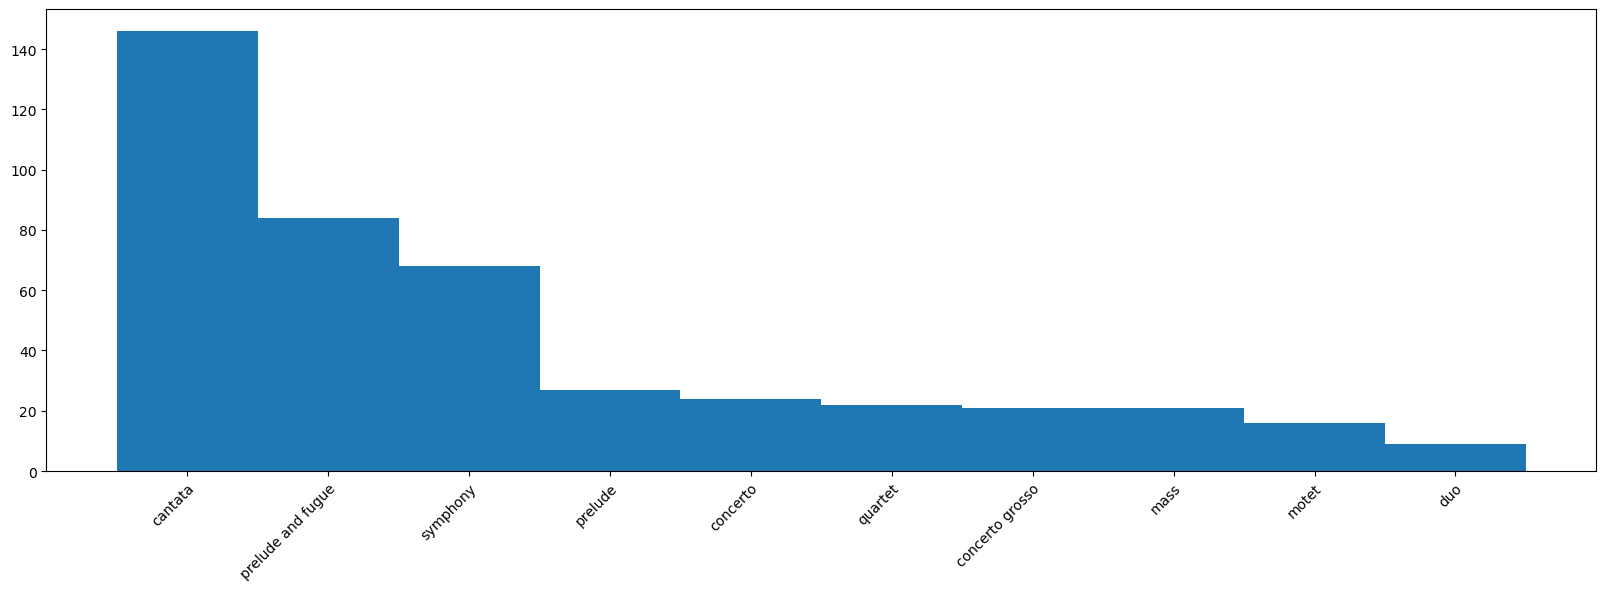

In [18]:
genres_filtered = caf(data, df.genre, 0)

# Encoding

In [19]:
lb = LabelBinarizer()
oh_labels = lb.fit_transform(df.genre.to_list())


In [21]:
lb.classes_

array(['cantata', 'concerto', 'concerto grosso', 'duo', 'mass', 'motet',
       'prelude', 'prelude and fugue', 'quartet', 'symphony'],
      dtype='<U17')

In [22]:
oh_labels.shape

(438, 10)

In [26]:
num_input, num_output = data.shape[1], oh_labels.shape[1]
num_input, num_output

(100, 10)

# Network

## Build

In [28]:
def create_model(num_in, num_out):
    def m():
        model = tf.keras.Sequential()

        model.add(layers.Dense(100, activation='relu', input_shape=(num_in,)))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(num_out, activation='sigmoid'))

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),
                    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

        return model
    return m


In [32]:
neural_network = KerasClassifier(model=create_model(num_input, num_output),
                                 epochs=10,
                                 batch_size=32,
                                 verbose=0)

## Train and Results

In [34]:
random_state = 2111
scores = cross_val_score(neural_network, data, oh_labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)
print(scores)
scores_genre = np.mean(scores)
scores_genre


[0.63636364 0.84090909 0.68181818 0.72727273 0.61363636 0.70454545
 0.75       0.72727273 0.8372093  0.74418605]


0.7263213530655392

In [36]:
print("{mean:.3f} +- {std:.3f}".format(mean=scores_genre,std=np.std(scores)))

0.726 +- 0.070
